# Startegy ATR dip buying

The supertrend determines the trend direction, then the strategy enters long when there is a down candle with volume double the 5 days average. The opposite is true for short setups.

to be continued

In [7]:
import plotly.io as pio
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np

In [13]:
# Load the CSV file
file_path = '/Users/gabrielefabietti/projects/fetch_data/data/BTCUSDT_perpetual_futures_12_months_hourly_sorted.csv'  # Adjust this path accordingly
data = pd.read_csv(file_path)

# Convert the timestamp to datetime and set as index
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

# Ensure the index is a DatetimeIndex
data.index = pd.to_datetime(data.index)

# Display the first few rows to inspect the data
print(data.head())
data.info()

                        open     high      low    close    volume  \
timestamp                                                           
2023-05-25 14:00:00  26324.1  26419.9  26267.5  26353.3  6256.710   
2023-05-25 15:00:00  26353.3  26377.3  26147.9  26216.5  6220.939   
2023-05-25 16:00:00  26216.5  26310.0  26200.2  26263.5  3636.470   
2023-05-25 17:00:00  26263.5  26393.9  26244.8  26345.9  4675.360   
2023-05-25 18:00:00  26345.9  26405.6  26323.1  26363.9  3468.026   

                         turnover  
timestamp                          
2023-05-25 14:00:00  1.648828e+08  
2023-05-25 15:00:00  1.632401e+08  
2023-05-25 16:00:00  9.546310e+07  
2023-05-25 17:00:00  1.231245e+08  
2023-05-25 18:00:00  9.143123e+07  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8640 entries, 2023-05-25 14:00:00 to 2024-05-19 13:00:00
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   open      8640 non-null   float64
 1   

/Users/gabrielefabietti/projects/jupyter/venv/lib/python3.12/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


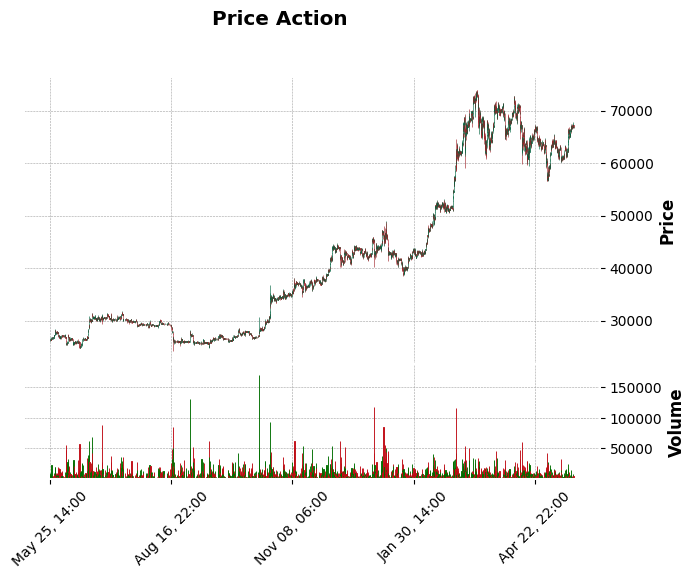

In [14]:
# Plot the candlestick chart
mpf.plot(data, type='candle', style='charles', title='Price Action', ylabel='Price', volume=True)

In [19]:
def calculate_atr(data, period=14):
    data['TR'] = np.maximum((data['high'] - data['low']), 
                            np.maximum(abs(data['high'] - data['close'].shift(1)), 
                                       abs(data['low'] - data['close'].shift(1))))
    data['ATR'] = data['TR'].rolling(window=period).mean()
    return data

def calculate_supertrend(data, atr_period=14, multiplier=3):
    data = calculate_atr(data, period=atr_period)
    
    data['UpperBand'] = ((data['high'] + data['low']) / 2) + (multiplier * data['ATR'])
    data['LowerBand'] = ((data['high'] + data['low']) / 2) - (multiplier * data['ATR'])
    data['Supertrend'] = np.nan
    
    for i in range(1, len(data)):
        if data['close'][i] > data['UpperBand'][i-1]:
            data['Supertrend'][i] = data['LowerBand'][i]
        elif data['close'][i] < data['LowerBand'][i-1]:
            data['Supertrend'][i] = data['UpperBand'][i]
        else:
            data['Supertrend'][i] = data['Supertrend'][i-1]
    
    return data

data = calculate_supertrend(data, atr_period=14, multiplier=3)

# Display the first few rows to verify the calculation
data.head()

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



,open,high,low,close,volume,turnover,TR,ATR,UpperBand,LowerBand,Supertrend
timestamp,,,,,,,,,,,
2023-05-25 14:00:00,26324.1,26419.9,26267.5,26353.3,6256.710,1.648828e+08,NaN,NaN,NaN,NaN,NaN
2023-05-25 15:00:00,26353.3,26377.3,26147.9,26216.5,6220.939,1.632401e+08,229.4,NaN,NaN,NaN,NaN
2023-05-25 16:00:00,26216.5,26310.0,26200.2,26263.5,3636.470,9.546310e+07,109.8,NaN,NaN,NaN,NaN
2023-05-25 17:00:00,26263.5,26393.9,26244.8,26345.9,4675.360,1.231245e+08,149.1,NaN,NaN,NaN,NaN
2023-05-25 18:00:00,26345.9,26405.6,26323.1,26363.9,3468.026,9.143123e+07,82.5,NaN,NaN,NaN,NaN


In [56]:
# Initialize a list to store setups
setups = []

da = 1

# Loop through the data to identify setups
for i in range(100, len(data) - da):  # Start from 100 to ensure enough data for the 100-period MA
    # Check if the 100-period MA is going up or down
    if data['close_MA_100'].iloc[i] > data['close_MA_100'].iloc[i-1]:
        trend = 'up'
    else:
        trend = 'down'
    
    # Check the volume condition
    if trend == 'up' and data['close'].iloc[i] < data['open'].iloc[i] and data['volume'].iloc[i] >= 2 * data['volume_MA'].iloc[i]:
        # Uptrend setup: down candle with volume >= 2 * 24-period MA volume
        price_diff_percentage = ((data['close'].iloc[i+da] - data['close'].iloc[i]) / data['close'].iloc[i]) * 100
        setups.append((data.index[i], 'long', price_diff_percentage))
    elif trend == 'down' and data['close'].iloc[i] > data['open'].iloc[i] and data['volume'].iloc[i] >= 2 * data['volume_MA'].iloc[i]:
        # Downtrend setup: up candle with volume >= 2 * 24-period MA volume
        price_diff_percentage = ((data['close'].iloc[i] - data['close'].iloc[i+da]) / data['close'].iloc[i]) * 100
        setups.append((data.index[i], 'short', price_diff_percentage))

# Convert setups to DataFrame
setups_df = pd.DataFrame(setups, columns=['timestamp', 'Setup', 'Price_Diff_Percentage'])


# Ensure 'Time' column in setups_df is a datetime
setups_df['timestamp'] = pd.to_datetime(setups_df['timestamp'])
# setups_df.set_index('timestamp', inplace=True)

In [57]:
print(setups_df)
mean_x_trade = setups_df['Price_Diff_Percentage'].mean()
print("Mean return per trade: ", round(mean_x_trade, 4), "%")

total_setups = len(setups_df)
positive_outcomes = (setups_df['Price_Diff_Percentage'] > 0).sum()
# Calculate the percentage of positive outcomes
percentage_positive = (positive_outcomes / total_setups) * 100

print(f"Percentage of positive outcomes: {percentage_positive:.2f}%")

long_setups = (setups_df['Setup'] == 'long').sum()
percentage_longs = long_setups / total_setups * 100

print(f"Percentage of long setups: {percentage_longs:.2f}%")

              timestamp  Setup  Price_Diff_Percentage
0   2023-05-31 04:00:00   long              -0.604161
1   2023-05-31 05:00:00   long               0.285083
2   2023-05-31 14:00:00   long              -0.468801
3   2023-06-01 00:00:00   long               0.033629
4   2023-06-01 16:00:00  short               0.513530
..                  ...    ...                    ...
259 2024-05-08 13:00:00  short              -0.193511
260 2024-05-11 15:00:00  short              -0.040875
261 2024-05-12 15:00:00  short               0.142189
262 2024-05-16 12:00:00   long               0.498408
263 2024-05-18 07:00:00   long               0.217052

[264 rows x 3 columns]
Mean return per trade:  -0.0042 %
Percentage of positive outcomes: 57.95%
Percentage of long setups: 59.09%


            timestamp  Setup  Price_Diff_Percentage  Capital_After_Trade
0 2023-05-31 04:00:00   long              -0.604161         99395.839145
1 2023-05-31 05:00:00   long               0.285083         99679.200129
2 2023-05-31 14:00:00   long              -0.468801         99211.903166
3 2023-06-01 00:00:00   long               0.033629         99245.266863
4 2023-06-01 16:00:00  short               0.513530         99754.921554
Final capital: 98452.25


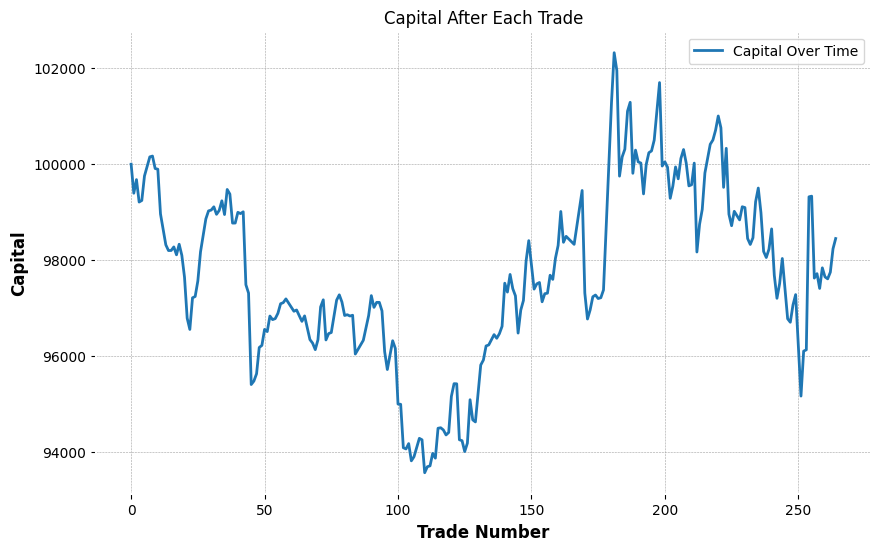

In [58]:
# Initialize capital
initial_capital = 100000
capital = initial_capital

# Initialize a list to track capital over time
capital_over_time = [capital]

# Simulate the strategy
for i, row in setups_df.iterrows():
    # Calculate the change in capital based on the price difference percentage
    capital_change = capital * (row['Price_Diff_Percentage']/100)
    capital += capital_change
    capital_over_time.append(capital)

# Add the capital over time to the setups_df for tracking
setups_df['Capital_After_Trade'] = capital_over_time[1:]  # Skip the initial capital entry

# Display the first few rows of the updated DataFrame
print(setups_df.head())

# Print final capital
print(f"Final capital: {capital:.2f}")

# Plot the capital over time
plt.figure(figsize=(10, 6))
plt.plot(capital_over_time, label='Capital Over Time')
plt.xlabel('Trade Number')
plt.ylabel('Capital')
plt.title('Capital After Each Trade')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Set the start and end date for the 5-day window
start_date = '2023-08-20'
end_date = '2023-09-10'

# Filter the data for this date range
filtered_data = data.loc[start_date:end_date]

"""
# Filter setups to include only those within the date range
filtered_setups = setups_df[(setups_df['timestamp'] >= pd.to_datetime(start_date)) & (setups_df['timestamp'] <= pd.to_datetime(end_date))]

# Display the filtered data and setups to verify
print(filtered_data.head())
print(filtered_setups.head())

print("N. of setups in this period: ",len(filtered_setups))
"""
print(filtered_data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 528 entries, 2023-08-20 00:00:00 to 2023-09-10 23:00:00
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   open      528 non-null    float64
 1   high      528 non-null    float64
 2   low       528 non-null    float64
 3   close     528 non-null    float64
 4   volume    528 non-null    float64
 5   turnover  528 non-null    float64
dtypes: float64(6)
memory usage: 28.9 KB
None


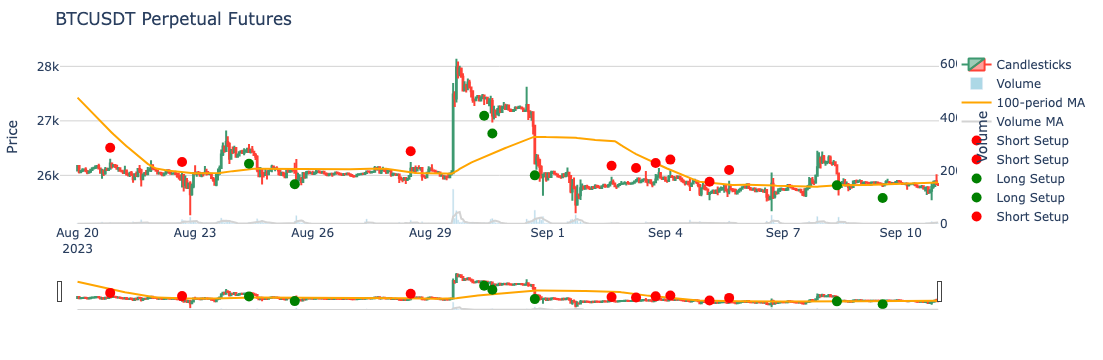

In [65]:
# Create the basic candlestick chart
fig = go.Figure()

# Add candlestick chart
fig.add_trace(go.Candlestick(
    x=filtered_data.index,
    open=filtered_data['open'],
    high=filtered_data['high'],
    low=filtered_data['low'],
    close=filtered_data['close'],
    name='Candlesticks'
))

# Add volume bars with lighter color and smaller scale
fig.add_trace(go.Bar(
    x=filtered_data.index,
    y=filtered_data['volume'] / 1000,  # Scale down volume
    name='Volume',
    marker_color='lightblue',
    yaxis='y2'  # Use secondary y-axis
))

# Add 100-period moving average
fig.add_trace(go.Scatter(
    x=filtered_data.index,
    y=filtered_data['close_MA_100'],
    mode='lines',
    name='100-period MA',
    line=dict(color='orange', width=2)
))

# Add 100-period moving average for volume
fig.add_trace(go.Scatter(
    x=filtered_data.index,
    y=filtered_data['volume_MA'] / 1000,  # Scale down volume MA
    mode='lines',
    name='Volume MA',
    line=dict(color='lightgrey', width=2),
    yaxis='y2'  # Use secondary y-axis
))

# Add setups annotations using small dots
for i, row in filtered_setups.iterrows():
    if row['Setup'] == 'short':
        fig.add_trace(go.Scatter(
            x=[row['timestamp']],
            y=[filtered_data.loc[row['timestamp'], 'high'] + 200],  # Small dot above the high of the candle
            mode='markers',
            marker=dict(color='red', size=10),
            name='Short Setup'
        ))
    elif row['Setup'] == 'long':
        fig.add_trace(go.Scatter(
            x=filtered_setups.index,
            y=[filtered_data.loc[row['timestamp'], 'low'] - 200],  # Small dot below the low of the candle
            mode='markers',
            marker=dict(color='green', size=10),
            name='Long Setup'
        ))

# Update layout to add secondary y-axis for volume and adjust the size and colors
fig.update_layout(
    height=800,  # Adjust height for a taller graph
    plot_bgcolor='white',  # Set background color to white
    yaxis=dict(
        title='Price',
        showgrid=True,
        gridcolor='lightgrey'
    ),
    yaxis2=dict(
        title='Volume',
        overlaying='y',
        side='right',
        showgrid=False,
        position=1.0,  # Move the secondary y-axis to the right
        range=[0, max(filtered_data['volume'] / 1000) * 5]  # Adjust the range for better visibility
    ),
    margin=dict(l=50, r=50, t=50, b=50),
    title='BTCUSDT Perpetual Futures'
)

# Show the plot
fig.show()